In [364]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [365]:
class Value:
    def __init__(self,data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data+other.data, (self,other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward

        return out
    def __radd__(self, other):
        return self + other
    
    def __neg__(self):
        return self * -1
    def __sub__(self,other):
        return self + (- other)
    
    def __mul__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self,other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self,other):
        return self * other ** -1

    def __pow__(self,other):
        assert isinstance(other,(int,float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self,),f'**{other}')

        def _backward():
            self.grad += other * self.data ** (other - 1) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x),(self,),'exp')

        def _backward():
            self.grad += out.data * out.grad
        
        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/ (math.exp(2*x)+1)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad += 1 - out.data ** 2 * out.grad
        
        out._backward = _backward

        return out
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [366]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label,n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot



In [152]:
#inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0,label='w2')
 #bias
b = Value(6.8813735870195532, label = 'b')

#raw activation without activation function
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

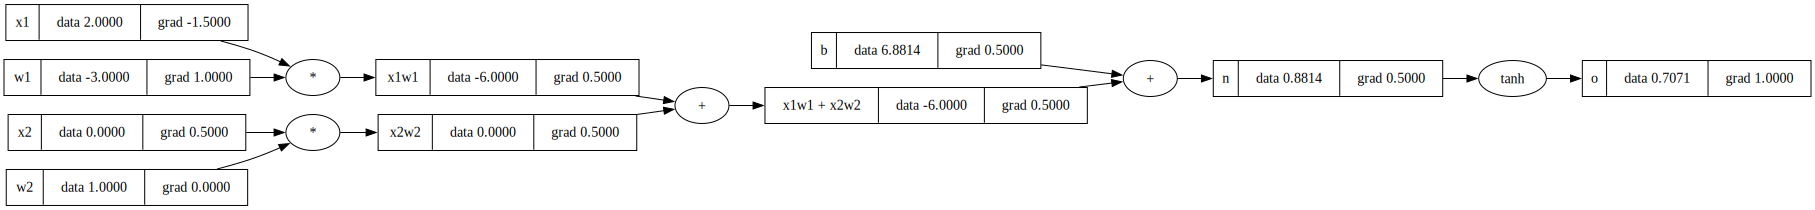

In [153]:
draw_dot(o)

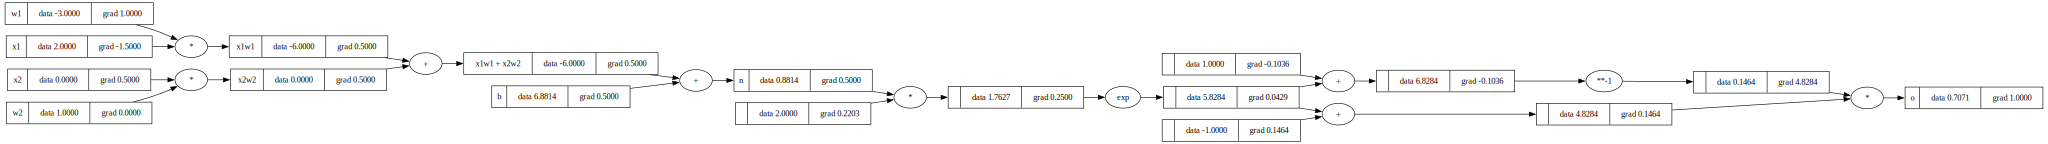

In [156]:
#inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0,label='w2')
 #bias
b = Value(6.8813735870195432, label = 'b')

#raw activation without activation function
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
# -----
e = (2*n).exp()
o = (e-1)/(e+1)
# -----
o.label = 'o'
o.backward()
draw_dot(o)

In [159]:
import torch

x1 = torch.Tensor([2.0]).double()               ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()               ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()              ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()               ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('-------')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())




0.7071066904050358
-------
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [387]:
import random

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    def __call__(self,x):
        # w + x + b
        act = sum((wi*xi for wi, xi in zip(self.w,x)), self.b)
        out = act.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    def parameters(self):
        return [p for nueron in self.neurons for p in nueron.parameters() ]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x;
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [388]:
x = [2.0,3.0, -1]
n = MLP(3,[4,4,1])
n(x)

Value(data=-0.9379974779073502)

In [384]:
xs = [
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0]
]
ys = [1.0,-1.0,-1.0,1.0]

In [386]:
for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(yout-ygt)**2 for ygt, yout in zip(ys, ypred)])
    
    # flust the grads to 0 so that they dont stack up
    for p in n.parameters():
        p.grad = 0.0

    # backward pass
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)

0 7.999999999769301
1 7.999999407913341
2 7.999999997366682
3 7.999999995482314
4 7.999999999722068
5 7.999999999988718
6 7.999999999997854
7 7.9999999999997335
8 7.9999999999999964
9 7.99999999999994


OverflowError: math range error

In [355]:
ypred

[Value(data=-0.9999999689531562),
 Value(data=-0.9999999689531562),
 Value(data=-0.9999999689531562),
 Value(data=-0.9999999689531562)]

In [389]:
n.parameters()

[Value(data=0.31447252922264757),
 Value(data=-0.775574842429217),
 Value(data=0.6804357783711221),
 Value(data=0.5038468220077463),
 Value(data=-0.4341578874377199),
 Value(data=0.5008150298622236),
 Value(data=0.051681074648219916),
 Value(data=-0.10331327738333318),
 Value(data=-0.654336262153387),
 Value(data=0.9715631585033666),
 Value(data=0.4715919619135891),
 Value(data=-0.20495505296332794),
 Value(data=-0.8444965154571495),
 Value(data=-0.7315179211101406),
 Value(data=0.8297055099650388),
 Value(data=0.35869603980099973),
 Value(data=-0.3001040345591919),
 Value(data=-0.47350392673938013),
 Value(data=0.16191820759772746),
 Value(data=-0.49798538590613495),
 Value(data=0.2353532827467142),
 Value(data=0.3600968401166671),
 Value(data=0.976384054534027),
 Value(data=0.7100936621813092),
 Value(data=0.5085506725761817),
 Value(data=-0.3195912604156219),
 Value(data=0.15007619645054882),
 Value(data=0.6112531162671726),
 Value(data=-0.8132369471820058),
 Value(data=-0.628436310